紅眼航班資料處理

In [29]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料並刪除價格歷史為空的列
data = pd.read_csv('/Users/yuchingchen/Documents/專題/data/history/tokyo_history_1020.csv')
data = data[['航班代碼', '出發時間', '價格歷史']].dropna(subset=['價格歷史'])

# 設定參考日期
reference_date = datetime.strptime("10/20", "%m/%d")

# 判斷是否為紅眼航班的函數
def is_red_eye_flight(departure_time):
    if "凌晨" in departure_time:
        try:
            time_obj = datetime.strptime(departure_time.replace("凌晨", "").replace("。", ""), "%I:%M")
            return 1 if 0 <= time_obj.hour < 6 else 0
        except ValueError:
            return 0
    return 0

data['紅眼航班'] = data['出發時間'].apply(is_red_eye_flight)

# 處理價格歷史，將日期轉換為剩餘天數，並計算歷史價格平均和最低價格
def process_price_history(history):
    entries = history.split(", ")
    remaining_days_with_prices = []
    prices = []
    
    for entry in entries:
        if "天前" in entry:
            days_ago = int(entry.split("天前")[0].strip())
            remaining_days = days_ago
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif "今天" in entry:
            remaining_days = 0
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif " - " in entry:
            date_str, price_str = entry.split(" - ")
            date_obj = datetime.strptime(date_str, "%m/%d")
            remaining_days = (reference_date - date_obj).days
            price = int(price_str.replace("$", "").replace(",", ""))
        else:
            continue

        remaining_days_with_prices.append((remaining_days, price))
        prices.append((price, remaining_days))
    
    avg_price = round(sum([p[0] for p in prices]) / len(prices)) if prices else None
    
    if prices:
        min_price = min([p[0] for p in prices])
        # 選取最後一個出現的最低價格對應的剩餘天數
        min_days_left = [days for price, days in prices if price == min_price][-1]
    else:
        min_price, min_days_left = None, None
    
    return remaining_days_with_prices, avg_price, min_price, min_days_left

# 對每一行的價格歷史應用處理函數並新增歷史價格平均、最低價格及其所有剩餘天數欄位
data[['剩餘天數及價格', '歷史價格平均', '最低價格', '最低價格剩餘天數']] = data['價格歷史'].apply(lambda x: pd.Series(process_price_history(x)))

# 刪除不需要的原始價格歷史欄位
data = data[['航班代碼', '出發時間', '剩餘天數及價格', '歷史價格平均', '最低價格', '最低價格剩餘天數', '紅眼航班']]

平均價格跟最低價格跟最低價格剩餘天數（按是否紅眼航班分類）

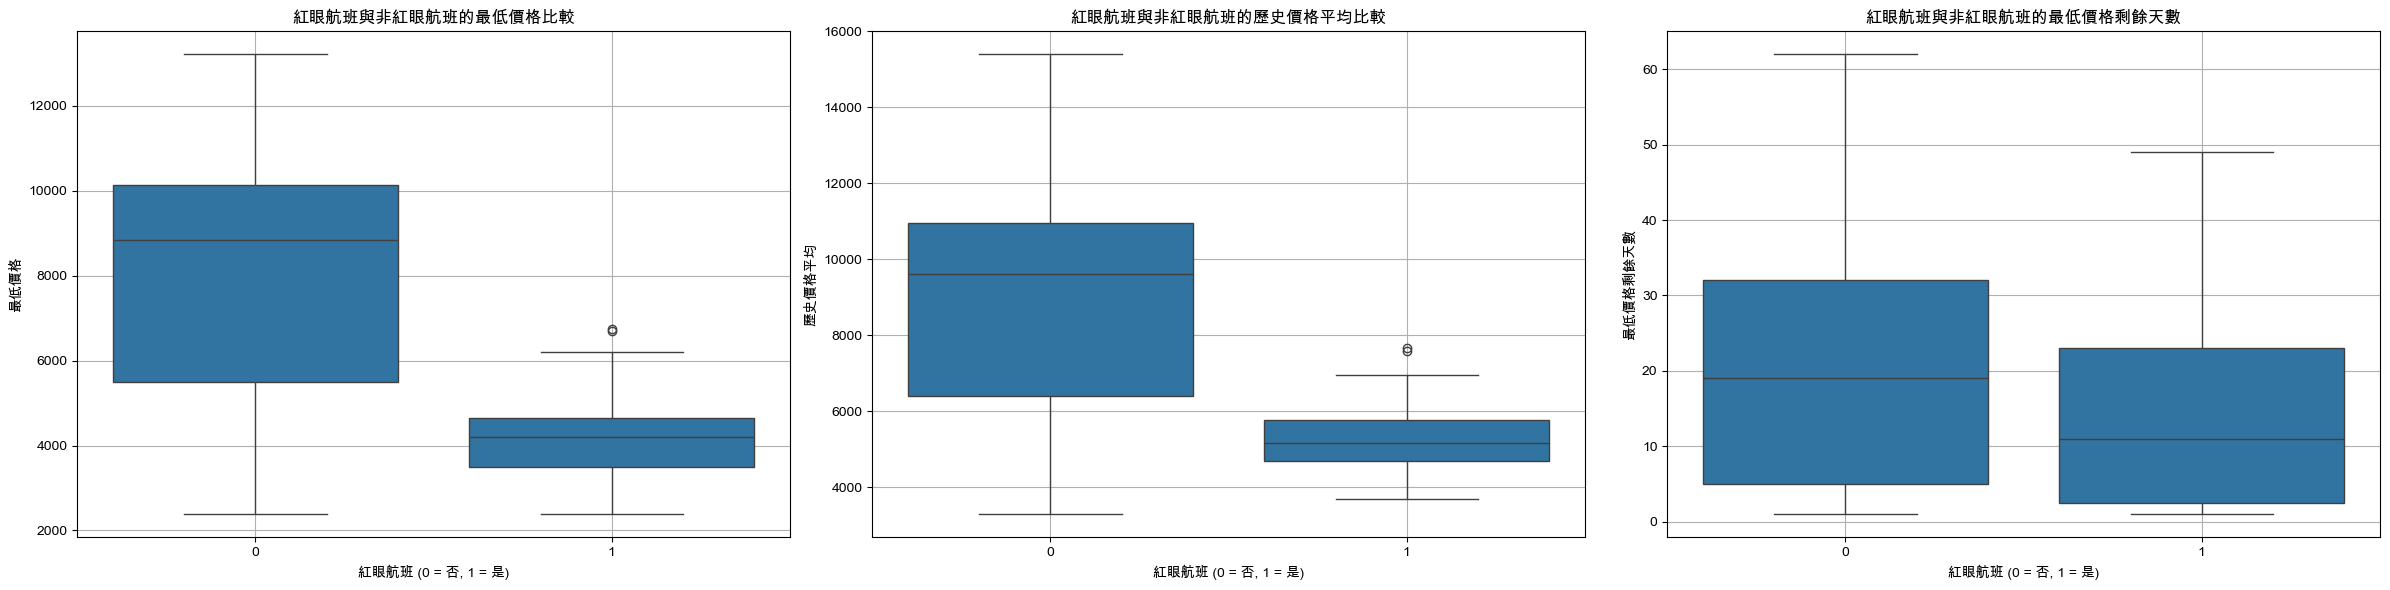

In [30]:
# 畫盒狀圖
# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 去除缺失值的資料
plot_data = data.dropna(subset=['航班代碼', '最低價格', '最低價格剩餘天數', '歷史價格平均'])

# 創建子圖，分別繪製最低價格、歷史價格平均和最低價格與剩餘天數的盒狀圖
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# 第一個子圖：紅眼航班與非紅眼航班的最低價格的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格', ax=axes[0])
axes[0].set_title('紅眼航班與非紅眼航班的最低價格比較')
axes[0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)')
axes[0].set_ylabel('最低價格')
axes[0].grid(True)

# 第二個子圖：紅眼航班與非紅眼航班的歷史價格平均的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='歷史價格平均', ax=axes[1])
axes[1].set_title('紅眼航班與非紅眼航班的歷史價格平均比較')
axes[1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)')
axes[1].set_ylabel('歷史價格平均')
axes[1].grid(True)

# 第三個子圖：紅眼航班與非紅眼航班的最低價格剩餘天數的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格剩餘天數', ax=axes[2])
axes[2].set_title('紅眼航班與非紅眼航班的最低價格剩餘天數')
axes[2].set_xlabel('紅眼航班 (0 = 否, 1 = 是)')
axes[2].set_ylabel('最低價格剩餘天數')
axes[2].grid(True)

plt.tight_layout()
plt.show()